# MULTICLASS CLASSIFICATION (AGE GROUP OF A PERSON)

In [76]:
import math
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
import umap
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import misc
from random import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical   

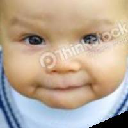

In [5]:
im =Image.open('UTKFace/1_0_0_20161219140623097.jpg.chip.jpg').resize((128,128))
im

The first character of the image file name tells us the age of the person

In [3]:
mypath = 'UTKFace'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [6]:
onlyfiles[:10]

['100_0_0_20170112213500903.jpg.chip.jpg',
 '100_0_0_20170112215240346.jpg.chip.jpg',
 '100_1_0_20170110183726390.jpg.chip.jpg',
 '100_1_0_20170112213001988.jpg.chip.jpg',
 '100_1_0_20170112213303693.jpg.chip.jpg',
 '100_1_0_20170112215032192.jpg.chip.jpg',
 '100_1_0_20170117195420803.jpg.chip.jpg',
 '100_1_0_20170119212053665.jpg.chip.jpg',
 '100_1_2_20170105174847679.jpg.chip.jpg',
 '100_1_2_20170112213615815.jpg.chip.jpg']

In [7]:
len(onlyfiles)

23708

In [13]:
len(onlyfiles)/5

4741.6

In [8]:
shuffle(onlyfiles)

In [9]:
age = [i.split('_')[0] for i in onlyfiles]

In [10]:
age[:10]

['24', '32', '45', '38', '16', '29', '33', '28', '46', '5']

### We can split the data into Classes 

- Children (1-14) CLASS 0
- Youth (14-25) CLASS 1
- ADULTS (25-40) CLASS 2
- Middle age (40-60) CLASS 3
- Very Old (>60) CLASS 4

In [82]:
classes = []
for i in age:
    i = int(i)
    if i <= 14:
        classes.append(0)
    if (i>14) and (i<=25):
        classes.append(1)
    if (i>25) and (i<40):
        classes.append(2)
    if (i>=40) and (i<60):
        classes.append(3)
    if i>=60:
        classes.append(4)

In [83]:
Counter(classes)

Counter({0: 3651, 1: 3986, 2: 8837, 3: 4544, 4: 2690})

### Convert the Images into vectors 

In [26]:
X_data =[]
os.chdir('UTKFace')
for file in onlyfiles:
    face = misc.imread(file)
    face =cv2.resize(face, (32, 32) )
    X_data.append(face)

In [27]:
X = np.squeeze(X_data)

In [28]:
X.shape

(23708, 32, 32, 3)

In [29]:
# normalize data
X = X.astype('float32')
X /= 255

Split the data into Train and Test

In [84]:
classes[:10]

[1, 2, 3, 2, 1, 2, 2, 2, 3, 0]

In [86]:
categorical_labels = to_categorical(classes, num_classes=5)

In [89]:
categorical_labels[:10]

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]])

In [104]:
(x_train, y_train), (x_test, y_test) = (X[:15008],categorical_labels[:15008]) , (X[15008:] , categorical_labels[15008:])

In [105]:
(x_valid , y_valid) = (x_test[:7000], y_test[:7000])

In [106]:
(x_test, y_test) = (x_test[7000:], y_test[7000:])

In [107]:
len(x_train)+len(x_test) + len(x_valid) == len(X)

True

In [95]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        8224      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
__________

In [96]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [97]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=10,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

Train on 15008 samples, validate on 7000 samples
Epoch 1/10
15008/15008 [==============================] - 28s 2ms/step - loss: 1.4159 - acc: 0.4068 - val_loss: 1.1918 - val_acc: 0.5071
Epoch 00001: val_loss improved from inf to 1.19177, saving model to model.weights.best.hdf5
Epoch 2/10
15008/15008 [==============================] - 14s 903us/step - loss: 1.1565 - acc: 0.5089 - val_loss: 1.0793 - val_acc: 0.5413
Epoch 00002: val_loss improved from 1.19177 to 1.07930, saving model to model.weights.best.hdf5
Epoch 3/10
15008/15008 [==============================] - 13s 899us/step - loss: 1.0807 - acc: 0.5439 - val_loss: 1.0020 - val_acc: 0.5697
Epoch 00003: val_loss improved from 1.07930 to 1.00198, saving model to model.weights.best.hdf5
Epoch 4/10
15008/15008 [==============================] - 13s 899us/step - loss: 1.0357 - acc: 0.5534 - val_loss: 0.9886 - val_acc: 0.5859
Epoch 00004: val_loss improved from 1.00198 to 0.98860, saving model to model.weights.best.hdf5
Epoch 5/10
15008/

In [98]:
model.load_weights('model.weights.best.hdf5')

In [109]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.6129411764705882


In [122]:
labels =["CHILD",  # index 0
        "YOUTH",      # index 1
        "ADULT",     # index 2 
        "MIDDLEAGE",        # index 3 
        "OLD",         # index 4
        ]

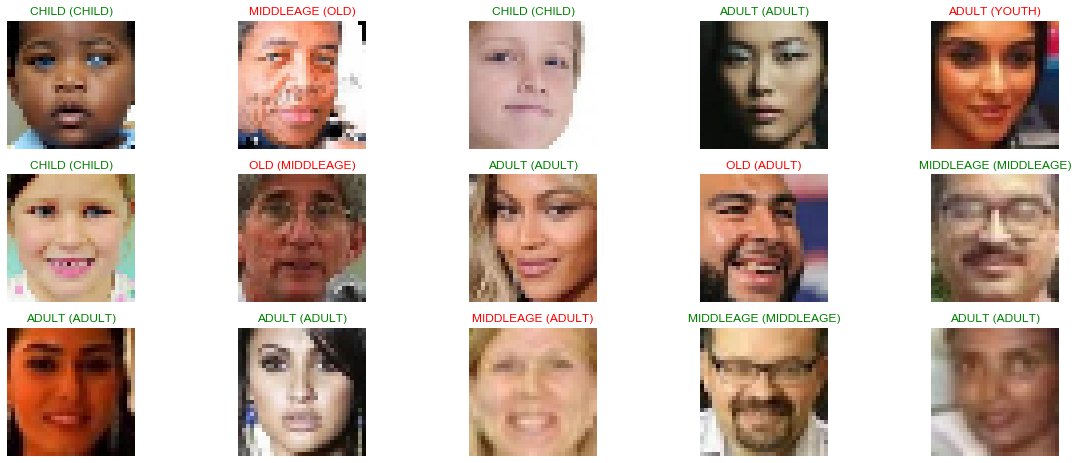

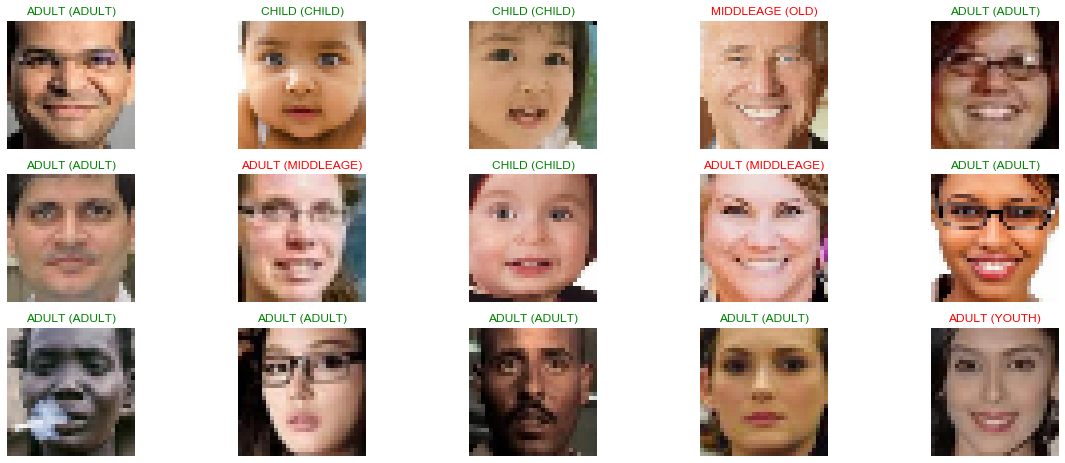

In [134]:
y_hat = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()